In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import ray
import pickle
import io
gin.enter_interactive_mode()
from causal_util import load_env
from causal_util.helpers import lstdct2dctlst
from sparse_causal_model_learner_rl.loss.losses import fit_loss
from sparse_causal_model_learner_rl.loss.causal_discriminator import siamese_feature_discriminator_l2, feature_causal_gan
from sparse_causal_model_learner_rl.trainable.discriminator import CausalFeatureActionModelDiscriminator
from sparse_causal_model_learner_rl.trainable.fcnet import FCNet

from sparse_causal_model_learner_rl.metrics.context_rewrite import context_rewriter
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices
from sparse_causal_model_learner_rl.config import Config
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL
from functools import partial

In [2]:
load_config_files(['../sparse_causal_model_learner_rl/configs/kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1.gin',
                   '../sparse_causal_model_learner_rl/configs/kc_dec.gin',
                   '../keychest/config/5x5_1f1c1k_obs.gin',
                   '../sparse_causal_model_learner_rl/configs/server_collect.gin'])

['kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1',
 'kc_dec',
 '5x5_1f1c1k_obs',
 'server_collect']

In [3]:
gin.bind_parameter('Config.env_steps', 5000)
gin.bind_parameter('Config.rl_multistep', [])
gin.bind_parameter('Config.env_steps', 5000)
gin.bind_parameter('Config.minibatch_size', 5000)
gin.bind_parameter('Normalizer.type_', 'meanstd')
gin.bind_parameter('ManyNetworkCombinedModel.input_batchnorm', True)

In [4]:
ray.init(ignore_reinit_error=True)

2021-02-09 07:19:40,211	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '10.90.38.7',
 'raylet_ip_address': '10.90.38.7',
 'redis_address': '10.90.38.7:50606',
 'object_store_address': '/tmp/ray/session_2021-02-09_07-19-39_543666_42215/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-02-09_07-19-39_543666_42215/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-02-09_07-19-39_543666_42215',
 'metrics_export_port': 61608,
 'node_id': '530285204d537f3ea712014a1504edd6c322c230'}

In [5]:
gin.bind_parameter('CausalFeatureActionModelDiscriminator.input_embedder_cls',
                   {'f_t': partial(FCNet, hidden_sizes=[], activation_cls=None),
                    'f_t1': partial(FCNet, hidden_sizes=[], activation_cls=None)
                   })
gin.bind_parameter('CausalFeatureActionModelDiscriminator.feature_embedding_dim', 30)
gin.bind_parameter('CausalFeatureActionModelDiscriminator.aggregator_cls',
                   partial(FCNet, hidden_sizes=[256, 128, 64], activation_cls=torch.nn.Tanh))
gin.bind_parameter('Config.causal_feature_action_model_discriminator', CausalFeatureActionModelDiscriminator)

In [6]:
# gin.bind_parameter('decoder/FCNet.hidden_sizes', [512, 256])
# gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [7]:
gin.bind_parameter('decoder/FCNet.hidden_sizes', [512])
gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [8]:
learner = CausalModelLearnerRL(Config(ray_kwargs={'address': '127.0.0.1:6379'}))

2021-02-09 07:19:42,290	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name cbe5ea0e-6a9e-11eb-8ff1-90e2baa1a248
Make environment KeyChest-v0 None {}


(pid=42487) Make environment KeyChest-v0 None {}
(pid=42488) Make environment KeyChest-v0 None {}
(pid=42583) Make environment KeyChest-v0 None {}
(pid=42553) Make environment KeyChest-v0 None {}
(pid=42492) Make environment KeyChest-v0 None {}
(pid=42509) Make environment KeyChest-v0 None {}
(pid=42542) Make environment KeyChest-v0 None {}



In [9]:
learner.create_trainables()

In [10]:
learner.causal_feature_action_model_discriminator

CausalFeatureActionModelDiscriminator(
  (model_f_t): FCNet(
    (fc01): Linear(in_features=30, out_features=30, bias=True)
  )
  (model_f_t1): FCNet(
    (fc01): Linear(in_features=32, out_features=30, bias=True)
  )
  (model_a_t): IdentityNet()
  (agg): FCNet(
    (fc01): Linear(in_features=64, out_features=256, bias=True)
    (fc02): Linear(in_features=256, out_features=128, bias=True)
    (fc03): Linear(in_features=128, out_features=64, bias=True)
    (fc04): Linear(in_features=64, out_features=1, bias=True)
  )
  (aggregator): FCNet(
    (fc01): Linear(in_features=64, out_features=256, bias=True)
    (fc02): Linear(in_features=256, out_features=128, bias=True)
    (fc03): Linear(in_features=128, out_features=64, bias=True)
    (fc04): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [11]:
learner.model

ManyNetworkCombinedModel(
  (bn): BatchNorm1d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (model): WithInputSwitch(
    (switch): LearnableSwitchSimple()
    (model): FCCombinedModel(
      (fc01): CombinedLinearLayer()
      (fc02): CombinedLinearLayer()
      (fc03): CombinedLinearLayer()
      (fc04): CombinedLinearLayer()
    )
  )
)

In [12]:
learner.decoder

ModelDecoder(
  (model): FCNet(
    (fc01): Linear(in_features=847, out_features=512, bias=True)
    (fc02): Linear(in_features=512, out_features=30, bias=True)
  )
)

In [13]:
env = learner.env

In [14]:
learner.decoder.__init__(observation_shape=learner.observation_shape,
                         feature_shape=learner.feature_shape)
learner.decoder = learner.decoder.cuda()

In [15]:
ctx = learner.collect_and_get_context()

In [16]:
feature_causal_gan(**ctx, loss_type='generator')

{'loss': tensor(2.0354, device='cuda:0', grad_fn=<AddBackward0>),
 'metrics': {'loss_env': 0.6447740793228149,
  'loss_env_permuted': 0.7440375089645386,
  'loss_model': 0.6465643048286438,
  'mean_logits_env': 0.09928412735462189,
  'mean_logits_env_permuted': 0.0992816835641861,
  'mean_logits_model': 0.09548337012529373}}

In [17]:
feature_causal_gan(**ctx, loss_type='discriminator')

{'loss': tensor(2.1309, device='cuda:0', grad_fn=<AddBackward0>),
 'metrics': {'loss_env': 0.6447740793228149,
  'loss_env_permuted': 0.7440426349639893,
  'loss_model': 0.7420476078987122,
  'mean_logits_env': 0.09928412735462189,
  'mean_logits_env_permuted': 0.09928296506404877,
  'mean_logits_model': 0.09548337012529373}}

In [18]:
features = learner.decoder(ctx['obs'])

In [19]:
f = features.detach().cpu().numpy()

In [20]:
f.shape

(5000, 30)

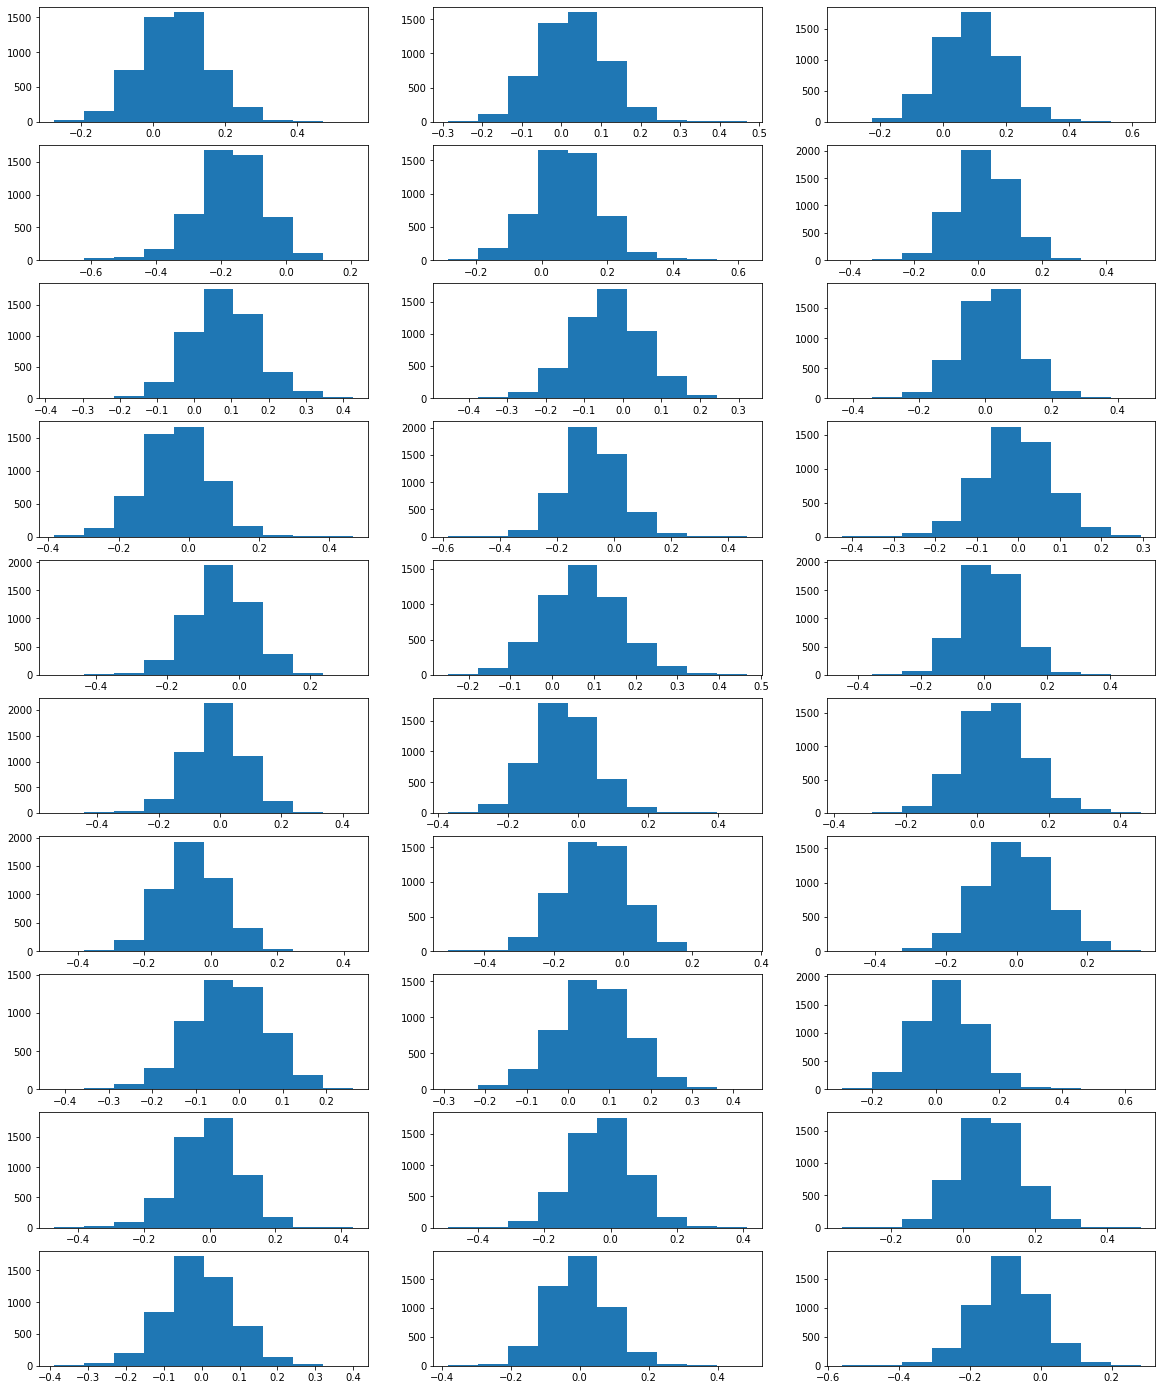

In [21]:
plt.figure(figsize=(20, 25))
for i_f in range(f.shape[1]):
    plt.subplot(10, 3, i_f + 1)
    plt.hist(f[:, i_f])

In [22]:
pd.DataFrame(f).std()

0     0.098995
1     0.087900
2     0.103300
3     0.105357
4     0.103750
5     0.090435
6     0.090035
7     0.091477
8     0.093694
9     0.093806
10    0.101307
11    0.086833
12    0.085953
13    0.092972
14    0.087167
15    0.095143
16    0.091587
17    0.097720
18    0.091173
19    0.097983
20    0.099921
21    0.089470
22    0.090923
23    0.098469
24    0.097216
25    0.097538
26    0.088504
27    0.090273
28    0.090062
29    0.094979
dtype: float32

<AxesSubplot:>

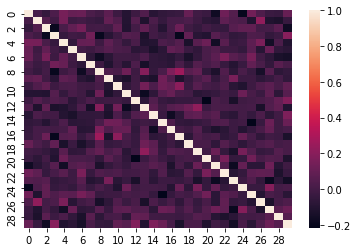

In [23]:
sns.heatmap(pd.DataFrame(f).corr())

In [24]:
env.engine.return_rgb = False

In [25]:
gin.bind_parameter('model_gnn/FCCombinedModel.activation_cls', torch.nn.Tanh)
gin.bind_parameter('model_gnn/FCCombinedModel.hidden_sizes', [100, 100, 100])
gin.bind_parameter('ManyNetworkCombinedModel.input_batchnorm', False)

In [26]:
learner.non_sparse_model.__init__(feature_shape=learner.feature_shape,
                                  action_shape=learner.action_shape,
                                  additional_feature_shape=learner.additional_feature_shape)
learner.non_sparse_model = learner.non_sparse_model.cuda()

In [27]:
learner.non_sparse_model.model.model.activation

[Tanh(), Tanh(), Tanh(), None]

In [28]:
learner.non_sparse_model

ManyNetworkCombinedModel(
  (model): WithInputSwitch(
    (switch): LearnableSwitchSimple()
    (model): FCCombinedModel(
      (fc01): CombinedLinearLayer()
      (fc02): CombinedLinearLayer()
      (fc03): CombinedLinearLayer()
      (fc04): CombinedLinearLayer()
    )
  )
)

In [29]:
learner.non_sparse_model.model.enable_switch

False

In [30]:
mins = None
maxes = None

In [31]:
def normalize(t, mins, maxes):
    return 2 * ((t - mins) / (1e-3 + maxes - mins) - 0.5)

In [32]:
class AdhocWorldModel(nn.Module):
    def __init__(self):
        super(AdhocWorldModel, self).__init__()
        dim = 60
        self.bn = torch.nn.BatchNorm1d(num_features=34)
        self.fc1 = nn.Linear(in_features=34, out_features=dim)
        self.fc2 = nn.Linear(in_features=dim, out_features=dim)
        self.fc3 = nn.Linear(in_features=dim, out_features=dim)
        self.fc4 = nn.Linear(in_features=dim, out_features=32)
        self.activation = nn.Tanh()
        
    def forward(self, f_t, a_t, all):
        x = torch.cat([f_t, a_t], dim=1)
        
        x = self.bn(x)
        
        x = self.fc1(x)
        x = self.activation(x)
        
        x = self.fc2(x)
        x = self.activation(x)
        
        x = self.fc3(x)
        x = self.activation(x)
        
        x = self.fc4(x)
        return x

In [33]:
metrics = []
losses_gen = []
losses_disc = []
ratios = []
ctx_set = False

In [34]:
use_model = learner.non_sparse_model
#use_model = AdhocWorldModel().cuda()

In [35]:
gin.bind_parameter('decoder/FCNet.hidden_sizes', [512, 256])
gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [36]:
learner.decoder.__init__(observation_shape=learner.observation_shape,
                         feature_shape=learner.feature_shape)
learner.decoder = learner.decoder.cuda()

In [37]:
opt_disc = torch.optim.Adam(lr=1e-3, params=list(learner.causal_feature_action_model_discriminator.parameters()) + list(learner.decoder.parameters()),
                      #amsgrad=True,
                       betas=(0.5, 0.8)
                      )
opt_gen = torch.optim.Adam(lr=1e-3, params=list(learner.decoder.parameters()) + list(use_model.parameters()),
                      #amsgrad=True,
                       betas=(0.5, 0.8)
                      )

In [38]:
[x.mean() for x in learner.decoder.state_dict().values()]

[tensor(4.6301e-05, device='cuda:0'),
 tensor(0.0012, device='cuda:0'),
 tensor(-2.9267e-05, device='cuda:0'),
 tensor(-4.7066e-05, device='cuda:0'),
 tensor(-0.0002, device='cuda:0'),
 tensor(-0.0051, device='cuda:0')]

In [ ]:
epochs = 500000
with tqdm(total=epochs) as pbar:
    for i in range(epochs):
        if i % 1 == 0 or not ctx_set:
            ctx_set = True
            ctx = learner.collect_and_get_context()
            ratio = ctx.get('context_stats_collected_sampled_ratio', None)
            if ratio:
                ratios.append(ratio)
            elif ratios:
                ratios.append(ratios[-1])

        ctx['non_sparse_model_add'] = use_model
        
        feature_causal_gan(**ctx, loss_type='generator')
        
        def get_loss_obj(loss_type):
            l_obj_fit = context_rewriter(function=feature_causal_gan, rewrite={'model': 'non_sparse_model_add'},
                                         **ctx,
                                         loss_type=loss_type)
            return l_obj_fit
        
        
        l_obj_disc = get_loss_obj('discriminator')
        l_obj_gen = get_loss_obj('generator')

        stage = (i // 2) % 2
        if stage == 0:
            # discriminator training
            
            loss = l_obj_disc['loss']
            
            opt_disc.zero_grad()
            loss.backward()
            opt_disc.step()
        elif stage == 1:
            # generator training
            loss = l_obj_gen['loss']
            
            opt_gen.zero_grad()
            loss.backward()
            opt_gen.step()
    
        losses_gen.append(l_obj_gen['loss'].item())
        losses_disc.append(l_obj_disc['loss'].item())
        m = {}
        m.update(l_obj_disc['metrics'])
        metrics.append(m)
        pbar.update(1)
        pbar.set_postfix(loss_gen=losses_gen[-1], loss_disc=losses_disc[-1], stage=stage)

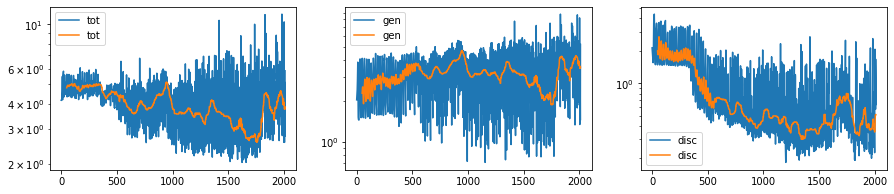

In [57]:
# multistep
plt.figure(figsize=(15, 3))
plt.subplot(1, 3, 1)
losses = np.array(losses_gen) + losses_disc
plt.plot(losses, label='tot')
plt.plot(pd.Series(losses).rolling(50).median(), label='tot')
plt.legend()
plt.yscale('log')

plt.subplot(1, 3, 2)
plt.plot(losses_gen, label='gen')
plt.plot(pd.Series(losses_gen).rolling(50).median(), label='gen')
plt.legend()
plt.yscale('log')
plt.subplot(1, 3, 3)
plt.plot(losses_disc, label='disc')
plt.plot(pd.Series(losses_disc).rolling(50).median(), label='disc')

plt.legend()
#plt.plot(dplus, label='dplus')
plt.yscale('log')

Text(0, 0.5, 'fit loss')

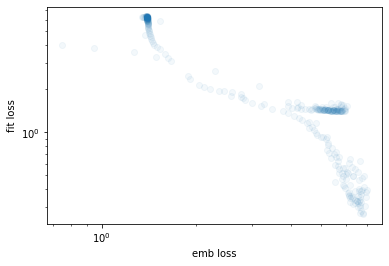

In [52]:
plt.scatter(losses_gen, losses_disc, alpha=0.05)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('emb loss')
plt.ylabel('fit loss')

In [53]:
%%javascript
var jq = document.createElement('script');
jq.src = "https://ajax.googleapis.com/ajax/libs/jquery/2.1.4/jquery.min.js";
document.getElementsByTagName('head')[0].appendChild(jq);

<IPython.core.display.Javascript object>

In [54]:
%load_ext jupyternotify
%autonotify -a 30

<IPython.core.display.Javascript object>

In [55]:
f_t1 = learner.decoder(ctx['obs_y'])#.detach()
f_t = learner.decoder(ctx['obs_x'])#.detach()

#         f_t1 = normalize(f_t1, mins, maxes)
#         f_t = normalize(f_t, mins, maxes)

add_features_y = torch.cat([ctx[k] for k in ctx['additional_feature_keys']], dim=1)
# f_t1 = torch.zeros_like(f_t1)
f_t1 = torch.cat([f_t1, add_features_y], dim=1)

f_t1_pred = use_model(
f_t,
ctx['action_x'],
all=True)


<AxesSubplot:>

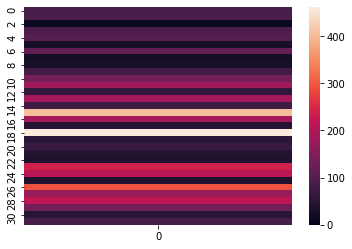

In [56]:
sns.heatmap((f_t1_pred - f_t1).pow(2).mean(0).cpu().detach().numpy().reshape(-1, 1), vmin=0)

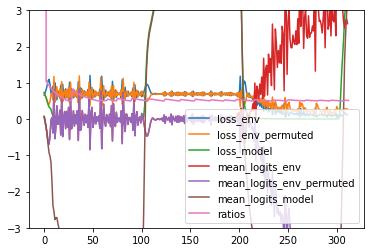

In [64]:
metrics_dct = lstdct2dctlst(metrics)
metrics_dct['ratios'] = ratios
for key, vals in metrics_dct.items():
    if len(np.array(vals).shape) > 1: continue
    plt.plot(vals, label=key)
plt.ylim((-3, 3))
plt.legend()
plt.show()

In [60]:
learner.decoder(ctx['obs_x']).min()

tensor(-120.2703, device='cuda:0', grad_fn=<MinBackward1>)

In [61]:
# metrics_dct['']

<AxesSubplot:>

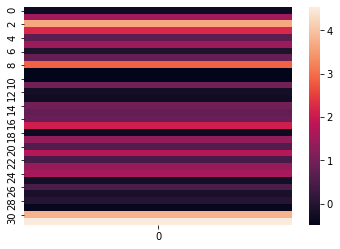

In [62]:
sns.heatmap(np.log(((f_t1_pred - f_t1).pow(2).mean(0) / f_t1.std(0).pow(2)).cpu().detach().numpy().reshape(-1, 1)))

<AxesSubplot:>

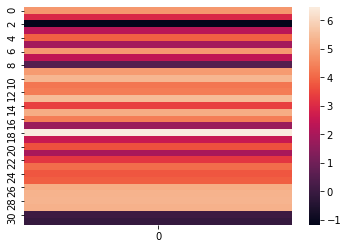

In [63]:
sns.heatmap(np.log(f_t1.std(0).pow(2).cpu().detach().numpy().reshape(-1, 1)))